# TC Profiling


In [90]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import seaborn

## NS / SFC / VNF Model

The first approach for a simplistic NS/ SFC / VNF performance model that can be used to play with different profiling approaches. As a first shot, the model tries to mimic the results from our NFV-SDN'17 paper [1]. The model focuses only on throughput as main metric for now. 

### Assumptions / Design

* A (network service) model instance consists of $n$ VNFs in a linear chain $f_1, ..., f_n$.
* Each VNF is represented by an arbitrary function $p_i$ that maps CPU-time to throughput: $p_i: c \rightarrow t_p$
* Each position in the chain has a scaling factor $\alpha$ assigned that influences the actual performance achieved by the VNF at that position. This models the changing performance behavior for changing VNF positions in the chain.
* These scaling factors are initialized with the model and might be randomized.
* The global (network service) throughput can be computed by giving a vector of CPU-times to the model: $(c_1, c_2, ... c_n)$ for $f_1, ..., f_n$
* The global (network service) throughput is computed as the minimum over all VNF throughputs combined with the positional scaling factor of their location: $min\{p_i(c_i)*\alpha_i\} \forall i \in [1, n]$.

### References

<small>
* [1] M. Peuster and H. Karl: Profile Your Chains, Not Functions: Automated Network Service Profiling in DevOps Environments. IEEE Conference on Network Function Virtualization and Software Defined Networks (NFV-SDN), Berlin, Germany. (2017) 
</small>

In [125]:
class NS(object):
    """
    A network service based on a linear SFC: f1 -> f2 -> ... -> fN 
    """
    
    def __init__(self, name, vnfs, alphas = None):
        """
        name: name of service (string)
        vnfs: vector of functions representing the VNF's CPU-time -> throughput mapping
        alphas: vector of floats to scale the performance of a VNF at the corresponding position (set to [1.0,...,1.0] if None)
        """
        self.name = name
        self.vnfs = vnfs
        self.alphas = alphas if alphas else [1.0 for _ in self.vnfs]
        print("Initialized '{}' with alphas={}".format(self.name, self.alphas))   
        
    def _calc_vnf_tp(self, cpu_times):
        """
        calculate TP for each function in self.vnfs
        cpu_times: CPU time available for each VNF
        """
        assert len(cpu_times) == len(self.vnfs) == len(self.alphas)
        # calculate result for each vnf and multiply by corresponding alpha
        return [f(r) * a for f, r, a in zip(self.vnfs, cpu_times, self.alphas)]
           
    def get_total_tp(self, cpu_times):
        """
        calculate TP of SFC
        cpu_times: CPU time available for each VNF
        """
        # uses "naive" minimum-TP model from NFV-SDN'17 paper for now
        return min(self._calc_vnf_tp(cpu_times))


In [113]:
#
# Model tests
#
# use simple linear models (based on NFV-SDN'17 paper results):
vnfs = [
    lambda x: 8.0 * x,  # nginx
    lambda x: 3.0 * x,  # socat
    lambda x: 1.2 * x   # squid
]

n1 = NS("n1", vnfs)
print(n1.get_total_tp([0.16, 0.16, 0.16]))
print(n1.get_total_tp([1.0, 1.0, 1.0]))
print(n1.get_total_tp([1.0, 1.0, 1.0]))

n2 = NS("n2", vnfs, alphas=[np.random.uniform(0.2, 5.0) for _ in vnfs])
print(n2.get_total_tp([0.16, 0.16, 0.16]))
print(n2.get_total_tp([1.0, 1.0, 1.0]))
print(n2.get_total_tp([1.0, 1.0, 1.0]))

Initialized 'n1' with alphas=[1.0, 1.0, 1.0]
0.192
1.2
1.2
Initialized 'n2' with alphas=[2.071160607392833, 1.2216815074451728, 3.787016937115103]
0.586407123573683
3.6650445223355184
3.6650445223355184


### Model Validation
Implements the experiment setup of our NFV-SDN'17 paper to check if the model produces outputs that look like the ones seen in our experiments.

Note: This is still very rough and does not fit perfectly. However the results roughly behave like the ones in our paper, so we use this for now (cf. the following plot with Fig. 4 of [1]).

#### Problems

* The positional scaling factors are uniformly distributed between 1.0 and 6.0 for now. This should be improved. Needs investigation of our measurement data. Maybe we find something that fits better.


Initialized 'NS_base' with alphas=[1.0, 1.0, 1.0]
Initialized 'NS_1' with alphas=[3.4854450772174506, 5.360170394997537, 2.151569833629016]
Initialized 'NS_2' with alphas=[3.4854450772174506, 5.360170394997537, 2.151569833629016]
Initialized 'NS_3' with alphas=[3.4854450772174506, 5.360170394997537, 2.151569833629016]
Generated 27 configs.


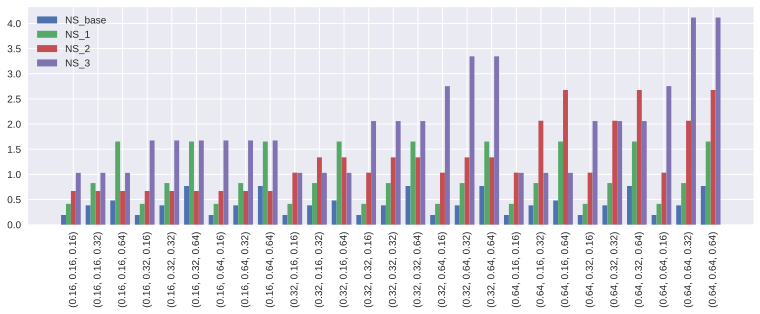

In [130]:
#
# Helper
#
def bar_plot_compare(configs, ns_list, ns_results):
    plt.figure(figsize=(13,4))
    X = np.arange(len(configs))
    bar_width = 1 / (len(ns_list) + 1)
    offset = 0
    for c, ns, r in zip(configs, ns_list, ns_results):
        plt.bar(X -(len(ns_list) / 2 * bar_width) + (bar_width * offset), r , width = bar_width, label=ns.name)
        offset += 1
    plt.xticks(X, configs, rotation=90)
    plt.legend()

def rotate(l, x):
    # permutate VNF list
    return l[-x:] + l[:-x]

#
# Model
#
# use simple linear models for VNFs (based on NFV-SDN'17 paper results):
vnfs = [
    lambda x: 8.0 * x,  # nginx
    lambda x: 3.0 * x,  # socat
    lambda x: 1.2 * x   # squid
]

# generate random alphas (NFV-SDN'17 paper shows variance up to 6.0x comp. to model)
alphas=[np.random.uniform(1.0, 6.0) for _ in vnfs]

# generate one service instance without any random effects
ns_list = list()
ns_base = NS("NS_base", vnfs.copy())
ns_list.append(ns_base)

# generate three service instances and rotate the order of the VNFs
# (scaling (alphas) for each position is random but fixed accross NS instances)
ns_1 = NS("NS_1", vnfs.copy(), alphas=alphas)
ns_list.append(ns_1)
ns_2 = NS("NS_2", rotate(vnfs.copy(), 1), alphas=alphas)
ns_list.append(ns_2)
ns_3 = NS("NS_3", rotate(vnfs.copy(), 2), alphas=alphas)
ns_list.append(ns_3)

# generate list with resource configurations to "profile"
configs = list()
for c1 in [0.16, 0.32, 0.64]:
    for c2 in [0.16, 0.32, 0.64]:
        for c3 in [0.16, 0.32, 0.64]:
            configs.append((c1, c2, c3))
print("Generated {} configs.".format(len(configs)))

# compute results
ns_results = list()
for ns in ns_list:
    ns_results.append([ns.get_total_tp(c) for c in configs])

# plot
bar_plot_compare(configs, ns_list, ns_results)

## Next Steps

* bla bla